## IMPORTS

In [89]:
import numpy as np
import math
from scipy.spatial.distance import euclidean
from scipy.optimize import linear_sum_assignment
from utils.angle import angle_mod, rot_mat_2d
from math import sin, cos, atan2, sqrt, acos, pi, hypot
from scipy.spatial import distance_matrix
from itertools import permutations
import matplotlib.pyplot as plt


## DTSP

In [90]:
"""

Dubins path planner sample code

author Atsushi Sakai(@Atsushi_twi)

"""

def plan_dubins_path(s_x, s_y, s_yaw, g_x, g_y, g_yaw, curvature,
                     step_size=0.1, selected_types=None):
    """
    Plan dubins path

    Parameters
    ----------
    s_x : float
        x position of the start point [m]
    s_y : float
        y position of the start point [m]
    s_yaw : float
        yaw angle of the start point [rad]
    g_x : float
        x position of the goal point [m]
    g_y : float
        y position of the end point [m]
    g_yaw : float
        yaw angle of the end point [rad]
    curvature : float
        curvature for curve [1/m]
    step_size : float (optional)
        step size between two path points [m]. Default is 0.1
    selected_types : a list of string or None
        selected path planning types. If None, all types are used for
        path planning, and minimum path length result is returned.
        You can select used path plannings types by a string list.
        e.g.: ["RSL", "RSR"]

    Returns
    -------
    x_list: array
        x positions of the path
    y_list: array
        y positions of the path
    yaw_list: array
        yaw angles of the path
    modes: array
        mode list of the path
    lengths: array
        arrow_length list of the path segments.

    Examples
    --------
    You can generate a dubins path.

    >>> start_x = 1.0  # [m]
    >>> start_y = 1.0  # [m]
    >>> start_yaw = np.deg2rad(45.0)  # [rad]
    >>> end_x = -3.0  # [m]
    >>> end_y = -3.0  # [m]
    >>> end_yaw = np.deg2rad(-45.0)  # [rad]
    >>> curvature = 1.0
    >>> path_x, path_y, path_yaw, mode, _ = plan_dubins_path(
                start_x, start_y, start_yaw, end_x, end_y, end_yaw, curvature)
    >>> plt.plot(path_x, path_y, label="final course " + "".join(mode))
    >>> plot_arrow(start_x, start_y, start_yaw)
    >>> plot_arrow(end_x, end_y, end_yaw)
    >>> plt.legend()
    >>> plt.grid(True)
    >>> plt.axis("equal")
    >>> plt.show()

    .. image:: dubins_path.jpg
    """
    if selected_types is None:
        planning_funcs = _PATH_TYPE_MAP.values()
    else:
        planning_funcs = [_PATH_TYPE_MAP[ptype] for ptype in selected_types]

    # calculate local goal x, y, yaw
    l_rot = rot_mat_2d(s_yaw)
    le_xy = np.stack([g_x - s_x, g_y - s_y]).T @ l_rot
    local_goal_x = le_xy[0]
    local_goal_y = le_xy[1]
    local_goal_yaw = g_yaw - s_yaw

    lp_x, lp_y, lp_yaw, modes, lengths = _dubins_path_planning_from_origin(
        local_goal_x, local_goal_y, local_goal_yaw, curvature, step_size,
        planning_funcs)

    # Convert a local coordinate path to the global coordinate
    rot = rot_mat_2d(-s_yaw)
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + s_x
    y_list = converted_xy[:, 1] + s_y
    yaw_list = angle_mod(np.array(lp_yaw) + s_yaw)

    return x_list, y_list, yaw_list, modes, lengths


def _mod2pi(theta):
    return angle_mod(theta, zero_2_2pi=True)


def _calc_trig_funcs(alpha, beta):
    sin_a = sin(alpha)
    sin_b = sin(beta)
    cos_a = cos(alpha)
    cos_b = cos(beta)
    cos_ab = cos(alpha - beta)
    return sin_a, sin_b, cos_a, cos_b, cos_ab


def _LSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "S", "L"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_a - sin_b))
    if p_squared < 0:  # invalid configuration
        return None, None, None, mode
    tmp = atan2((cos_b - cos_a), d + sin_a - sin_b)
    d1 = _mod2pi(-alpha + tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(beta - tmp)
    return d1, d2, d3, mode


def _RSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "S", "R"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_b - sin_a))
    if p_squared < 0:
        return None, None, None, mode
    tmp = atan2((cos_a - cos_b), d - sin_a + sin_b)
    d1 = _mod2pi(alpha - tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(-beta + tmp)
    return d1, d2, d3, mode


def _LSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = -2 + d ** 2 + (2 * cos_ab) + (2 * d * (sin_a + sin_b))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((-cos_a - cos_b), (d + sin_a + sin_b)) - atan2(-2.0, d1)
    d2 = _mod2pi(-alpha + tmp)
    d3 = _mod2pi(-_mod2pi(beta) + tmp)
    return d2, d1, d3, mode


def _RSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = d ** 2 - 2 + (2 * cos_ab) - (2 * d * (sin_a + sin_b))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((cos_a + cos_b), (d - sin_a - sin_b)) - atan2(2.0, d1)
    d2 = _mod2pi(alpha - tmp)
    d3 = _mod2pi(beta - tmp)
    return d2, d1, d3, mode


def _RLR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "L", "R"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (sin_a - sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(alpha - atan2(cos_a - cos_b, d - sin_a + sin_b) + d2 / 2.0)
    d3 = _mod2pi(alpha - beta - d1 + d2)
    return d1, d2, d3, mode


def _LRL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "R", "L"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (- sin_a + sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(-alpha - atan2(cos_a - cos_b, d + sin_a - sin_b) + d2 / 2.0)
    d3 = _mod2pi(_mod2pi(beta) - alpha - d1 + _mod2pi(d2))
    return d1, d2, d3, mode


_PATH_TYPE_MAP = {"LSL": _LSL, "RSR": _RSR, "LSR": _LSR, "RSL": _RSL,
                  "RLR": _RLR, "LRL": _LRL, }


def _dubins_path_planning_from_origin(end_x, end_y, end_yaw, curvature,
                                      step_size, planning_funcs):
    dx = end_x
    dy = end_y
    d = hypot(dx, dy) * curvature

    theta = _mod2pi(atan2(dy, dx))
    alpha = _mod2pi(-theta)
    beta = _mod2pi(end_yaw - theta)

    best_cost = float("inf")
    b_d1, b_d2, b_d3, b_mode = None, None, None, None

    for planner in planning_funcs:
        d1, d2, d3, mode = planner(alpha, beta, d)
        if d1 is None:
            continue

        cost = (abs(d1) + abs(d2) + abs(d3))
        if best_cost > cost:  # Select minimum length one.
            b_d1, b_d2, b_d3, b_mode, best_cost = d1, d2, d3, mode, cost

    lengths = [b_d1, b_d2, b_d3]
    x_list, y_list, yaw_list = _generate_local_course(lengths, b_mode,
                                                      curvature, step_size)

    lengths = [length / curvature for length in lengths]

    return x_list, y_list, yaw_list, b_mode, lengths


def _interpolate(length, mode, max_curvature, origin_x, origin_y,
                 origin_yaw, path_x, path_y, path_yaw):
    if mode == "S":
        path_x.append(origin_x + length / max_curvature * cos(origin_yaw))
        path_y.append(origin_y + length / max_curvature * sin(origin_yaw))
        path_yaw.append(origin_yaw)
    else:  # curve
        ldx = sin(length) / max_curvature
        ldy = 0.0
        if mode == "L":  # left turn
            ldy = (1.0 - cos(length)) / max_curvature
        elif mode == "R":  # right turn
            ldy = (1.0 - cos(length)) / -max_curvature
        gdx = cos(-origin_yaw) * ldx + sin(-origin_yaw) * ldy
        gdy = -sin(-origin_yaw) * ldx + cos(-origin_yaw) * ldy
        path_x.append(origin_x + gdx)
        path_y.append(origin_y + gdy)

        if mode == "L":  # left turn
            path_yaw.append(origin_yaw + length)
        elif mode == "R":  # right turn
            path_yaw.append(origin_yaw - length)

    return path_x, path_y, path_yaw


def _generate_local_course(lengths, modes, max_curvature, step_size):
    p_x, p_y, p_yaw = [0.0], [0.0], [0.0]

    for (mode, length) in zip(modes, lengths):
        if length == 0.0:
            continue

        # set origin state
        origin_x, origin_y, origin_yaw = p_x[-1], p_y[-1], p_yaw[-1]

        current_length = step_size
        while abs(current_length + step_size) <= abs(length):
            p_x, p_y, p_yaw = _interpolate(current_length, mode, max_curvature,
                                           origin_x, origin_y, origin_yaw,
                                           p_x, p_y, p_yaw)
            current_length += step_size

        p_x, p_y, p_yaw = _interpolate(length, mode, max_curvature, origin_x,
                                       origin_y, origin_yaw, p_x, p_y, p_yaw)

    return p_x, p_y, p_yaw

In [91]:
def mean_angle(v1, v2):
    return (v1 + v2) / np.linalg.norm(v1 + v2)

In [92]:
def etsp(points):
    dist_matrix = distance_matrix(points, points)
    n = len(points)
    min_length = float('inf')
    best_path = None
    
    for perm in permutations(range(n)):
        current_length = sum(dist_matrix[perm[i], perm[i+1]] for i in range(n-1))
        current_length += dist_matrix[perm[-1], perm[0]]
        
        if current_length < min_length:
            min_length = current_length
            best_path = perm
            
    return [points[i] for i in best_path]


In [93]:
def dtsp(points, curvature):
    n = len(points)
    Q = []
    PΣ = etsp(points)  # Solução inicial para o ETSP
    
    for i in range(n):
        pi = np.array(PΣ[i])
        pi_ant = np.array(PΣ[(i - 1) % n])
        pi_sup = np.array(PΣ[(i + 1) % n])
        v1 = (pi - pi_ant)/np.linalg.norm(pi - pi_ant)
        v2 = (pi_sup - pi)/np.linalg.norm(pi_sup - pi)
        orientation_angle_pi = mean_angle(v1, v2)

        n1 = np.exp(-(np.linalg.norm(pi - pi_ant) - (2 * curvature)) / (curvature / 2))
        n2 = np.exp(-(np.linalg.norm(pi_sup - pi) - (2 * curvature)) / (curvature / 2))
        
        if n1 > n2:
            new_orientation_angle_pi = v1 - orientation_angle_pi
        else:
            new_orientation_angle_pi = v2 - orientation_angle_pi
        
        λ = abs(n1 - n2)
        orientation_angle_pi = orientation_angle_pi + (λ * new_orientation_angle_pi)
        qi = (PΣ[i], orientation_angle_pi)
        Q.append(qi)
    return Q


## TESTES

### TESTE 1

In [94]:
# points = np.array([
#         [0, 0],
#         [2, 4],
#         [3, 1],
#         [3, 2]
#     ])


### TESTE 2

In [95]:
# points = np.array([[0,0], [0.5, 0.8], [1,2], [2,1], [-1,-2], [1.5, 1.5]])

### TESTE 3

In [96]:
points = np.array([
        [0,0],
        [-1.5, -1.8],
        [-1.5, 2.5],
        [1.5, 2.5],
        [1.5, -1.8]
    ])

In [97]:
curvature = 1.0
# curvature = 0.5
configurations = dtsp(points, curvature)
print(configurations)

for i, (point, angle) in enumerate(configurations):
        print(f"Point {i}: {point}, Angle: {angle}")

[(array([0., 0.]), array([-0.27036746, -0.91848792])), (array([-1.5, -1.8]), array([ 0.03229137, -0.85501381])), (array([ 1.5, -1.8]), array([0.74380145, 0.61851801])), (array([1.5, 2.5]), array([-0.74380145,  0.61851801])), (array([-1.5,  2.5]), array([-0.46759383, -0.86988318]))]
Point 0: [0. 0.], Angle: [-0.27036746 -0.91848792]
Point 1: [-1.5 -1.8], Angle: [ 0.03229137 -0.85501381]
Point 2: [ 1.5 -1.8], Angle: [0.74380145 0.61851801]
Point 3: [1.5 2.5], Angle: [-0.74380145  0.61851801]
Point 4: [-1.5  2.5], Angle: [-0.46759383 -0.86988318]


## PLOTS

### PLOT Solução sem curvas de Dubins

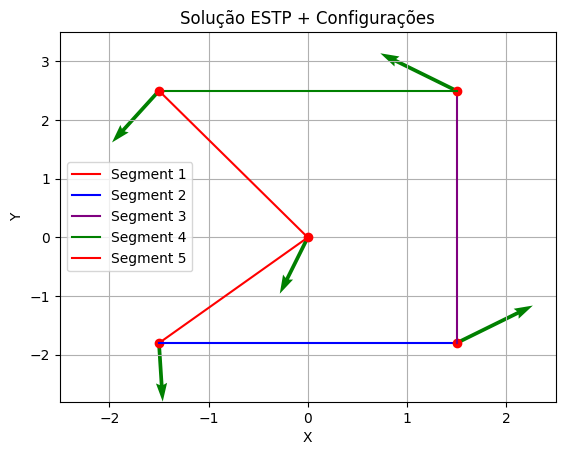

In [98]:
# Lista de cores
colors = ['red', 'blue', 'purple', 'green']

def plot_estp_path(configurations):
    n = len(configurations)
    fig, ax = plt.subplots()
    for i in range(n):
        point, vector = configurations[i]
        norm_vector = vector/np.linalg.norm(vector)
        end_point, vector_point = configurations[(i + 1 ) % n]
        ax.plot(point[0], point[1], 'ro')  # Plota o ponto em azul
        ax.quiver(point[0], point[1], norm_vector[0], norm_vector[1], angles='xy', scale_units='xy', scale=1, color='green')  # Plota o vetor
        ax.plot([point[0], end_point[0]], [point[1], end_point[1]], colors[i % 4], label=f"Segment {i+1}")
    X = np.array([point[0][0] for point in configurations])
    Y = np.array([point[0][1] for point in configurations])
    margin = 1  # Margem adicional para melhor visualização
    ax.set_xlim(X.min() - margin, X.max() + margin)
    ax.set_ylim(Y.min() - margin, Y.max() + margin)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Solução ESTP + Configurações')
    plt.grid()
    ax.legend()
    plt.show()

plot_estp_path(configurations)

### PLOT Solução com curvas de Dubins

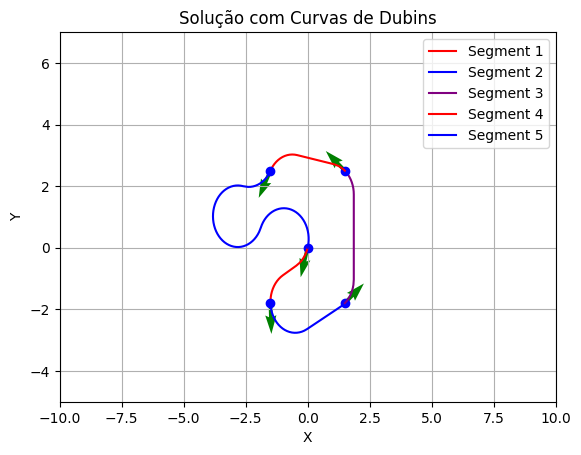

Distância Total =  22.940577336992433


In [99]:

def calculate_orientation_angle(vector):
    return np.arctan2(vector[1], vector[0])


def plot_dubins_path(configurations):
    n = len(configurations)
    fig, ax = plt.subplots()
    final_distance = 0
    for i in range(n):
        point, vector = configurations[i]
        end_point, vector_point = configurations[(i + 1 ) % n]
        norm_vector = vector/np.linalg.norm(vector)

        plt.plot(point[0], point[1], 'bo')  # Plota o ponto em azul
        plt.quiver(point[0], point[1], norm_vector[0], norm_vector[1], angles='xy', scale_units='xy', scale=1, color='green')  # Plota o vetor

        s_yaw = calculate_orientation_angle(vector)
        e_yaw = calculate_orientation_angle(vector_point)
        path_x, path_y, path_yaw, mode, lengths = plan_dubins_path(point[0],
                                                            point[1],
                                                            s_yaw,
                                                            end_point[0],
                                                            end_point[1],
                                                            e_yaw,
                                                            curvature)
        ax.plot(path_x, path_y, colors[i % 3], label=f"Segment {i+1}")
        final_distance += sum(lengths)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5, 7)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Solução com Curvas de Dubins')
    plt.grid()
    ax.legend()
    plt.show()
    print("Distância Total = ", final_distance)

plot_dubins_path(configurations)